# RNN Exemple pour les Séries Temporelles

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Données

Publication : Ventes mensuelles anticipées pour le commerce de détail et les services de restauration  

Unités :  Millions de dollars, pas d'ajustement de saisonnalité

Fréquence :  Mensuelle

La valeur pour le mois le plus récent est une estimation anticipée qui est basée sur les données d'un sous-échantillon d'entreprises de l'enquête mensuelle sur le commerce de détail, plus importante. L'estimation anticipée sera remplacée au cours des mois suivants par des estimations révisées issues de l'enquête mensuelle sur le commerce de détail, plus vaste. Les séries associées de l'enquête mensuelle sur le commerce de détail sont disponibles à l'adresse suivante : https://fred.stlouisfed.org/series/MRTSSM448USN

Des informations sur l'enquête mensuelle anticipée sur les ventes au détail sont disponibles sur le site web du recensement à l'adresse suivante : https://www.census.gov/retail/marts/about_the_surveys.html

Citation suggérée :
U.S. Census Bureau, Advance Retail Sales : Clothing and Clothing Accessory Stores [RSCCASN], extrait de FRED, Federal Reserve Bank of St. Louis ; https://fred.stlouisfed.org/series/RSCCASN, 16 novembre 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [13]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [14]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [15]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

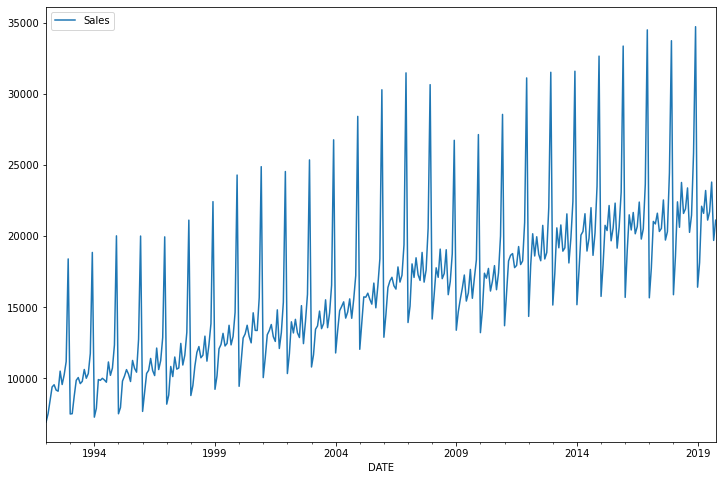

In [16]:
df.plot(figsize=(12,8))

## Répartition Entraînement / Test

In [17]:
len(df)

334

Les données sont mensuelles, prévoyons un an et demi dans le futur.

In [18]:
len(df)- 18

316

In [19]:
test_size = 18

In [20]:
test_ind = len(df)- test_size

In [21]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [22]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [23]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Mise à l'échelle des données

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()

In [26]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [27]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Générateur de séries temporelles

Cette classe examine une série de points de données recueillis à
des intervalles égaux, ainsi que des paramètres de séries temporelles tels stride, length , etc., afin de produire des lots pour
l'entraînement/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [29]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [30]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [31]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Cela prédit ce y : 
 [[0.02047633]]


## Création du Modèle

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [33]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [34]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation

REMARQUE : la taille de l'ensemble de données scaled_test DOIT être supérieure à la longueur choisie pour vos batchs.

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [38]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [39]:
# ajustement du modèle
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0335 - val_loss: 0.0027
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0161 - val_loss: 0.0068
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0119 - val_loss: 0.0020
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0090 - val_loss: 7.7566e-04
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0017


In [40]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

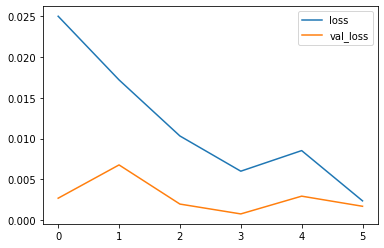

In [41]:
losses.plot()

## Évaluation sur les données de test

In [42]:
first_eval_batch = scaled_train[-length:]

In [43]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [44]:
model.predict(first_eval_batch)

array([[0.47616345]], dtype=float32)

In [45]:
scaled_test[0]

array([0.61087714])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.

----

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Transformations inverses et Comparaison

In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

<ipython-input-48-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [49]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,20053.445982
2018-06-01,21589,19086.649581
2018-07-01,21919,19309.529502
2018-08-01,23381,20959.147106
2018-09-01,20260,18728.230857
2018-10-01,21473,19245.545567
2018-11-01,25831,22984.999708
2018-12-01,34706,32456.549626
2019-01-01,16410,15650.980817


<AxesSubplot:xlabel='DATE'>

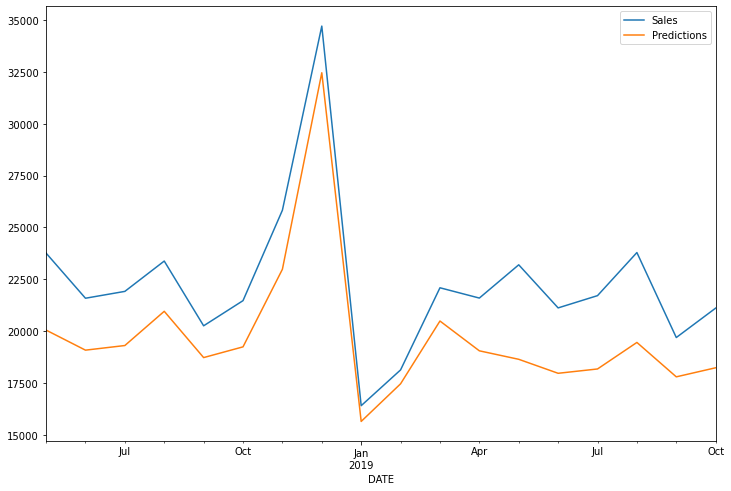

In [50]:
test.plot(figsize=(12,8))

## Ré-Entraînement et Prévision

In [51]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [52]:
length = 12 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [53]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# ajustement du modèle
model.fit(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 2s 3ms/step - loss: 0.0358
Epoch 2/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0152
Epoch 3/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0071
Epoch 4/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 5/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0040
Epoch 6/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 7/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0017
Epoch 8/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0014


In [54]:
forecast = []
# Remplacez les périodes par la durée de prévision que vous souhaitez
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
forecast = full_scaler.inverse_transform(forecast)

### Création d'un nouvel index TimeStamp avec Pandas

In [56]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [57]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [58]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [59]:
forecast_df

,Forecast
2019-11-01,24028.345916
2019-12-01,32881.160916
2020-01-01,16398.558442
2020-02-01,17732.946182
2020-03-01,20399.339970
2020-04-01,20078.635036
2020-05-01,21326.466746
2020-06-01,19753.252785
2020-07-01,20226.642513
2020-08-01,21870.328224


<AxesSubplot:>

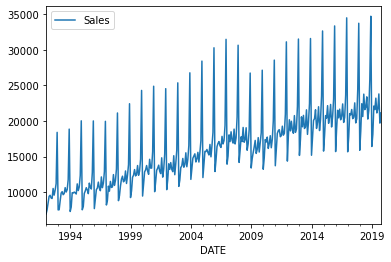

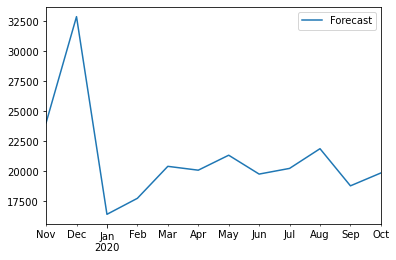

In [60]:
df.plot()
forecast_df.plot()

### Unir les graphiques avec Pandas

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<AxesSubplot:xlabel='DATE'>

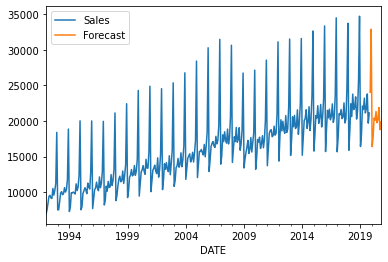

In [61]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

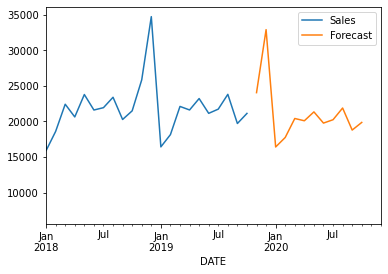

In [62]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')